# FRC Match Simulator
#### by Mark JP Sanchez

## Table of Contents
0. What is FRC?
1. Introduction
2. Initial Data
3. Data Cleaning and Engineering
4. Exploratory Data Analysis (EDA)
5. The Predictive Models
6. Conclusion
7. Seeing How Our Friends Are Doing

# 0.What is FRC?
FIRST Robotics Competition (FRC) is an international high school robotics competition which is run by FIRST. High schoolers are tasked with building a robot in 6 weeks for a game that changes every year. Sometimes robots are required to climb and scale structures, sometimes they are required shoot plastic balls into small opening and sometimes they are required to place boxes on a giant scale.

The way each competition works is that all the teams participating face each other off in a round robin style tournament where they will be partnered up with two other random teams to face another alliance of 3. After the round robin tournament, the top 8 teams will be given a chance to choose two other teams to form their own alliance. These alliances will then face each other in an elimination style tournament where the last remaining alliance are the champions of the competition.

More info can be found here: https://www.firstinspires.org/

## 1.Introduction

We will use various predictive models to predict the outcome of matches. This may help teams with choosing their alliance partners. All data is gathered from https://www.thebluealliance.com/apidocs/v3. We will explore the data and engineer some features to help our predictive models. All the code for gathering the data and combining the data https://github.com/Mark-of-JP/FRC-Match-Simulator.

The result of this project is a model that predicts the outcome of a match with around 70% accuracy.

## 2.The Initial Data
From *data_collector.py* we gather data for matches, awards and teams. We then put that data into three csv's. There is a lot of unneeded data which we will clean out later.

First we should run the required imports for any data science project:

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing, metrics

Here is the data gotten from */teams* endpoint of the api:

In [43]:
#Dropping the Unnamed column since it is just a column container the index of each row
team_df = pd.read_csv('raw_frc_teams.csv').drop(columns=['Unnamed: 0'])
team_df.head()

,address,city,country,gmaps_place_id,gmaps_url,home_championship,key,awards,lat,lng,location_name,motto,name,nickname,postal_code,rookie_year,school_name,state_prov,team_number,website
0,NaN,Pontiac,USA,NaN,NaN,{'2020': 'Detroit'},frc1,36,NaN,NaN,NaN,NaN,FCA Foundation/Hirotec America/Molex&Oakland S...,The Juggernauts,48340,1997.0,Oakland Schools Technical Campus Northeast,Michigan,1,http://www.juggernautsteam1.com
1,NaN,Van Nuys,USA,NaN,NaN,{'2020': 'Houston'},frc4,12,NaN,NaN,NaN,NaN,Boston Scientific/Aerojet Rocketdyne/Raytheon/...,Team 4 ELEMENT,91406,1997.0,High Tech Los Angeles,California,4,http://www.team4element.com
2,NaN,Melvindale,USA,NaN,NaN,NaN,frc5,10,NaN,NaN,NaN,NaN,Ford FIRST Robotics & Melvindale High School,Robocards,NaN,1998.0,NaN,MI,5,http://www.robocards.org
3,NaN,Plymouth,USA,NaN,NaN,NaN,frc6,1,NaN,NaN,NaN,NaN,ATK (Alliant Techsystems) & Hopkins High School,The CogSquad,NaN,1994.0,NaN,MN,6,http://www.cogsquad.org
4,NaN,Baltimore,USA,NaN,NaN,NaN,frc7,8,NaN,NaN,NaN,NaN,Lockheed Martin/Northrop Grumman/Oak Harbor Ma...,Team007,NaN,NaN,NaN,MD,7,http://www.team007.org


In [44]:
#Show the columns
team_df.columns

Index(['address', 'city', 'country', 'gmaps_place_id', 'gmaps_url',
       'home_championship', 'key', 'awards', 'lat', 'lng', 'location_name',
       'motto', 'name', 'nickname', 'postal_code', 'rookie_year',
       'school_name', 'state_prov', 'team_number', 'website'],
      dtype='object')

Here is the data gotten from the */event/{event_key}/matches* endpoint of the api. All the event keys were collected beforehand using the same api:

In [45]:
#Dropping the Unnamed column since it is just a column container the index of each row
match_df = pd.read_csv('raw_frc_matches.csv').drop(columns=['Unnamed: 0'])
match_df.head()

,actual_time,red_score,red_0,red_1,red_2,blue_score,blue_0,blue_1,blue_2,comp_level,event_key,key,match_number,predicted_time,set_number,time,winning_alliance
0,NaN,32,frc111,frc175,NaN,20,frc22,frc45,NaN,ef,2000cmp,2000cmp_ef1m1,1,NaN,1,NaN,red
1,NaN,31,frc80,frc111,NaN,37,frc45,frc340,NaN,ef,2000cmp,2000cmp_ef1m2,2,NaN,1,NaN,blue
2,NaN,34,frc80,frc111,NaN,28,frc45,frc340,NaN,ef,2000cmp,2000cmp_ef1m3,3,NaN,1,NaN,red
3,NaN,13,frc47,frc312,NaN,23,frc126,frc131,NaN,ef,2000cmp,2000cmp_ef3m1,1,NaN,3,NaN,blue
4,NaN,14,frc312,frc201,NaN,28,frc126,frc131,NaN,ef,2000cmp,2000cmp_ef3m2,2,NaN,3,NaN,blue


In [46]:
#Show the columns
match_df.columns

Index(['actual_time', 'red_score', 'red_0', 'red_1', 'red_2', 'blue_score',
       'blue_0', 'blue_1', 'blue_2', 'comp_level', 'event_key', 'key',
       'match_number', 'predicted_time', 'set_number', 'time',
       'winning_alliance'],
      dtype='object')

Here is the data gotten from the */team/{team_key}/awards* endpoint of the api. All the team keys were collected beforehand using the same api:

In [47]:
#Dropping the Unnamed column since it is just a column container the index of each row
awards_df = pd.read_csv('raw_frc_awards.csv').drop(columns=['Unnamed: 0'])
awards_df.head()

,recipient,award_type,event_key,year
0,frc1,44,1998cmp,1998
1,frc1,17,1998mi,1998
2,frc1,1,1999cmp,1999
3,frc1,20,1999il,1999
4,frc1,2,1999mi,1999


In [48]:
#Show the columns
awards_df.columns

Index(['recipient', 'award_type', 'event_key', 'year'], dtype='object')

## 3.Data Cleaning and Combining
With all of our data collected it is now time to combine all of our data for our use case. The code use to generate the use case csv can be found in *data_cleaning_and_feature_engineering.ipynb*.

Here is the result of that code: (Note that if red_won is 1 then the red alliance won the match)

In [49]:
#Reads the csv and drops the index column
df = pd.read_csv('frc_use_case.csv').drop(columns=["Unnamed: 0"])
#2016 is a year to build elo and the other stats so we take on 2017->2020\
df = df[df.year >= 2017]
df

,red_score,red_0,red_1,red_2,blue_score,blue_0,blue_1,blue_2,comp_level,event_key,key,match_number,set_number,time,winning_alliance,year,red_won,red_avg_match_awards,red_avg_other_awards,blue_avg_match_awards,blue_avg_other_awards,red_avg_winrate,red_avg_games_played,blue_avg_winrate,blue_avg_games_played,red_avg_age,blue_avg_age,red_points_ratio_season,red_points_avg,red_avg_winrate_season,red_avg_games_played_season,blue_points_avg,blue_avg_winrate_season,blue_avg_games_played_season,red_elo,blue_elo,elo_prediction,avg_match_awards_diff,avg_other_awards_diff,avg_winrate_diff,avg_games_played_diff,avg_age_diff,avg_winrate_diff_season,avg_games_played_diff_season,red_opr,blue_opr,opr_ratio
13557,85,frc6324,frc4905,frc1517,97,frc1519,frc811,frc125,qm,2017week0,2017week0_qm1,1,1,2017-02-18 13:45:00,blue,2017,0,3.000000,3.000000,17.333333,18.000000,0.542169,27.666667,0.689076,79.333333,5.000000,15.333333,1.000000,-1.000000,0.500000,0.000000,-1.000000,0.500000,0.000000,1511.111941,1625.896997,0.340570,-14.333333,-15.000000,-0.146907,-51.666667,-10.333333,0.000000,0.000000,NaN,NaN,1.00000
13558,45,frc238,frc885,frc157,105,frc1153,frc4761,frc5687,qm,2017week0,2017week0_qm2,2,1,2017-02-18 13:55:00,blue,2017,0,3.333333,12.000000,4.666667,7.000000,0.592814,55.666667,0.572254,57.666667,19.333333,6.666667,1.000000,-1.000000,0.500000,0.000000,-1.000000,0.500000,0.000000,1542.981175,1541.507460,0.502121,-1.333333,5.000000,0.020560,-2.000000,12.666667,0.000000,0.000000,NaN,NaN,1.00000
13559,85,frc1289,frc509,frc58,81,frc5813,frc2079,frc501,qm,2017week0,2017week0_qm3,3,1,2017-02-18 14:05:00,red,2017,1,3.333333,9.666667,4.333333,7.000000,0.371134,32.333333,0.492063,42.000000,16.666667,9.000000,1.000000,-1.000000,0.500000,0.000000,-1.000000,0.500000,0.000000,1462.769491,1496.889503,0.451055,-1.000000,2.666667,-0.120929,-9.666667,7.666667,0.000000,0.000000,NaN,NaN,1.00000
13560,45,frc319,frc1831,frc88,85,frc78,frc2342,frc190,qm,2017week0,2017week0_qm4,4,1,2017-02-18 14:15:00,blue,2017,0,5.666667,13.666667,8.000000,19.000000,0.629442,65.666667,0.576923,52.000000,16.666667,18.333333,1.000000,-1.000000,0.500000,0.000000,-1.000000,0.500000,0.000000,1566.957524,1535.644622,0.544941,-2.333333,-5.333333,0.052519,13.666667,-1.666667,0.000000,0.000000,NaN,NaN,1.00000
13561,95,frc3467,frc1729,frc1058,100,frc1721,frc2084,frc885,qm,2017week0,2017week0_qm5,5,1,2017-02-18 14:25:00,blue,2017,0,5.000000,9.000000,1.666667,4.666667,0.582915,66.333333,0.476190,42.000000,10.333333,12.000000,1.000000,-1.000000,0.500000,0.000000,-1.000000,0.000000,0.333333,1546.673212,1491.112287,0.579284,3.333333,4.333333,0.106724,24.333333,-1.666667,0.500000,-0.333333,NaN,NaN,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72786,88,frc6025,frc6417,frc8158,122,frc8084,frc7285,frc3646,sf,2020tuis2,2020tuis2_sf2m2,2,2,2020-03-11 12:45:00,blue,2020,0,1.666667,3.000000,2.333333,2.333333,0.563380,47.333333,0.568493,48.666667,2.333333,3.666667,0.907030,87.906355,0.683333,20.000000,96.916667,0.638889,12.000000,1562.297390,1544.775330,0.525195,-0.666667,0.666667,-0.005113,-1.333333,-1.333333,0.044444,8.000000,122.0,133.0,0.99989
72787,151,frc6989,frc7296,frc7536,99,frc6064,frc7758,frc6459,sf,2020tuis2,2020tuis2_sf1m3,3,1,2020-03-11 12:52:00,red,2020,1,0.000000,0.000000,0.666667,2.000000,0.446154,21.666667,0.415254,39.333333,1.666667,2.666667,0.864242,90.121212,0.630435,15.333333,104.277778,0.750000,12.000000,1509.234597,1505.349513,0.505591,-0.666667,-2.000000,0.030900,-17.666667,-1.000000,-0.119565,3.333333,136.0,133.0,1.00003
72788,42,frc6989,frc7296,frc7536,125,frc8084,frc7285,frc3646,f,2020tuis2,2020tuis2_f1m1,1,1,2020-03-11 13:06:00,blue,2020,0,0.000000,0.000000,2.333333,2.333333,0.446154,21.666667,0.568493,48.666667,1.666667,3.666667,0.977687,94.083612,0.653061,16.333333,96.230769,0.666667,13.000000,1514.178689,1550.027279,0.448592,-2

In [50]:
df.columns

Index(['red_score', 'red_0', 'red_1', 'red_2', 'blue_score', 'blue_0',
       'blue_1', 'blue_2', 'comp_level', 'event_key', 'key', 'match_number',
       'set_number', 'time', 'winning_alliance', 'year', 'red_won',
       'red_avg_match_awards', 'red_avg_other_awards', 'blue_avg_match_awards',
       'blue_avg_other_awards', 'red_avg_winrate', 'red_avg_games_played',
       'blue_avg_winrate', 'blue_avg_games_played', 'red_avg_age',
       'blue_avg_age', 'red_points_ratio_season', 'red_points_avg',
       'red_avg_winrate_season', 'red_avg_games_played_season',
       'blue_points_avg', 'blue_avg_winrate_season',
       'blue_avg_games_played_season', 'red_elo', 'blue_elo', 'elo_prediction',
       'avg_match_awards_diff', 'avg_other_awards_diff', 'avg_winrate_diff',
       'avg_games_played_diff', 'avg_age_diff', 'avg_winrate_diff_season',
       'avg_games_played_diff_season', 'red_opr', 'blue_opr', 'opr_ratio'],
      dtype='object')

### How was this data cleaned and combine?
#### Removing unneeded colums
First of all, columns were removed from each of the data sets like the gmaps_url columns from teams data set due to either being irrelevant for our use case or had too many missing values.

We also removed the matches that only contained less than 3 people per alliance since it seems like the 3v3 system wasn't adopted until later years so it wouldn't make sense to train a model on outdated data.

Matches container demo robots such as the frc team with the team key 'frc9999' were also removed since those matches might not be indicative of an actual frc match.

In [51]:
print(str(team_df['gmaps_url'].isna().sum()) + " rows don't have a gmaps_url out of " + str(len(team_df)) + ' teams.')
print(str(match_df['red_2'].isna().sum()) + " matches did not have a 3rd red alliance member.")

7345 rows don't have a gmaps_url out of 7345 teams.
8202 matches did not have a 3rd red alliance member.


#### Considering Our Use Case
Next we thought about our use case and realized that for different matches, the same team might have different stats such as the amount of awards they have received due to the passage of time. So we dropped all the rows that did not contain any time. Looking at what we have left, we dropped the rows that did were held on years that had a large majority of its matches missing due to time.

This left us with matches from 2016-2020. 2016 will be used to build up elo and other statistics so models will be trained using 2017 to 2020.

In [52]:
print('We came from ' + str(len(match_df)) + ' matches to ' + str(len(df)) + ' matches after dropping everything.')

We came from 163001 matches to 59234 matches after dropping everything.


#### Iterating Through The Matches
After we had valid match data we then sorted them in ascending order according to their time and we collected and inserted data for each match. For each match we added each alliance's average winrate and then applied the results of those matches to our current winrate calculations. We did the same thing for things such as the average number of matches.

We seperated this data into overall team stats and the team stat for the season.
#### And the Award Goes To
For the awards each team has garnered we decided to split them up into two sections. The match awards, which were awards given to you because of your success in the matches, and the other awards. Chairman's award, Winner award, Finalist award, Rookie All Star award and the Highest Rookie Seed award were considered as the match awards. The other awards include things like the Entrepreneurship award and the Safety award.

To get the award data for each match we first gave all of the teams the awards they got before 2016. Each match has an event key that designates what event those matches were taken place at. So while we iterate through the matches, once we see that an event has ended we then award all the teams the awards they would have gotten for that event since awards are given after an event.
#### A Pointer on Points
One difficulty that was being faced was the fact that every year a new game would be played which meant that the average number of points and the max number of points a team can get changed every year. To somewhat counter this problem, average points between teams were represented as a ratio between the average points scored by the red alliance and the average points scored by the blue alliance. This way if an alliance beats their opponent by having double their points, it will be represented no matter what the year.

*Note: a -1 for avg points implies that a member of that alliance has not played a game that season. For red_points_ratio_season, if an alliance has a -1 as their average points then red_points_ratio_season is 1.*

#### Elo
An elo system was set up and tracked for the years 2016-2020. This elo system had a starting value of 1500 for all new teams. Using Elo gave us a way to rank teams against each other using purely their previous wins and losses as well as also giving us a trusted predictive model to compare our models to.

#### Offensive Power Rating (OPR)
The OPR system is a system used by some FIRST Robotics teams that is based off of the sports rating system. OPR attempts to assign an OPR value to each team. The OPR of a team is the predicted amount of points they will contribute. We calculated the OPR of each team through some matrix equations. In essence, we assumed each team contributes will consistently contribute the same amount of points to all of its matches, turned all the matches into a system of linear equations and solved the Ax=B matrix that represents the system of linear equations using the least squares solution.

A more in-depth explanation of OPR and how we calculated it can be found in **data_cleaning_and_feature_engineering.ipynb**.

For our **opr_ratio** feature, we offset each opr by 100,000 to get rid of any negative oprs. We then divided the red alliance's opr by the blue alliance's opr. If we are unable to calculate the opr of an alliance for any reason then we set the ratio to be 1. The OPR values that are being shown are the OPR's of each alliance for that competition/event.

More information on OPR can also be found here: https://blog.thebluealliance.com/2017/10/05/the-math-behind-opr-an-introduction/

#### Feature Explanations
A quick explanation on the interesting features. Features with the **season** suffix represent the result of that feature for the specified season/year.

**avg_age_diff**: The difference between the average age of each alliance.

**avg_games_played_diff**: The difference between the average number games each alliance has played.

**avg_match_awards_diff**: The difference between the average number of *match* awards each alliance has.

**avg_match_other_diff**: The difference between the average number of *other* awards each alliance has.

**avg_winrate_diff**: (# of wins from each team in the alliance) / (total number of matches each team has played in the alliance)

**elo_prediction**: The prediction given by using the blue alliance's elo (blue_elo) and red alliance's elo (red_elo)

**opr_ratio**: (red_opr + 100,000) / (blue_opr + 100,000)

**red_points_ratio**: (avg score from the current red alliance for the season)/(avg score from the current blue alliance for the season)

## 4.Exploratory Data Analysis (EDA)
Now that our use case data is set up and ready lets see what kind of information it can give us.

In [53]:
#Dropping the year since describing them won't really mean anything
df.drop(columns=['year']).describe()

,red_score,blue_score,match_number,set_number,red_won,red_avg_match_awards,red_avg_other_awards,blue_avg_match_awards,blue_avg_other_awards,red_avg_winrate,red_avg_games_played,blue_avg_winrate,blue_avg_games_played,red_avg_age,blue_avg_age,red_points_ratio_season,red_points_avg,red_avg_winrate_season,red_avg_games_played_season,blue_points_avg,blue_avg_winrate_season,blue_avg_games_played_season,red_elo,blue_elo,elo_prediction,avg_match_awards_diff,avg_other_awards_diff,avg_winrate_diff,avg_games_played_diff,avg_age_diff,avg_winrate_diff_season,avg_games_played_diff_season,red_opr,blue_opr,opr_ratio
count,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59233.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59233.000000,59234.000000,59234.000000,44603.000000,44602.000000,59234.000000
mean,185.770841,179.116791,33.395752,1.178529,0.529206,4.875173,7.670634,4.366569,7.078120,0.519677,73.011356,0.511611,70.457688,7.865289,7.692277,1.017659,159.616860,0.538572,20.397559,158.766778,0.525758,20.106994,1536.354039,1528.133053,0.511117,0.508604,0.592514,0.008066,2.553669,0.172933,0.012814,0.290565,183.066946,174.630465,1.000066
std,130.810591,125.588975,27.237028,0.591458,0.499150,4.993114,6.868394,4.373068,6.375322,0.086053,48.693957,0.081619,46.596028,3.994201,3.947890,0.378993,106.677875,0.128482,17.108515,106.005826,0.121480,16.772268,71.005763,62.347179,0.099849,5.565236,7.906308,0.111278,38.554283,4.615414,0.157269,7.203790,192.632177,202.555810,0.002335
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.100000,0.000000,0.000000,0.000000,0.144340,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1375.605085,1356.163999,0.037730,-35.333333,-40.666667,-0.550371,-261.666667,-19.666667,-1.000000,-60.666667,-7334.000000,-20074.000000,0.905717
25%,64.000000,62.000000,7.000000,1.000000,0.000000,1.666667,2.333333,1.333333,2.333333,0.464968,35.333333,0.460870,34.666667,4.666667,4.666667,0.946438,52.619099,0.460317,7.666667,52.210645,0.455696,7.666667,1489.571647,1487.787432,0.453588,-2.000000,-3.666667,-0.062044,-17.333333,-2.666667,-0.075623,-2.333333,61.000000,58.000000,0.999870
50%,165.000000,159.000000,30.000000,1.000000,1.000000,3.333333,5.666667,3.000000,5.333333,0.518072,61.666667,0.510949,59.666667,7.666667,7.333333,1.001239,173.955357,0.539683,15.000000,173.878263,0.527273,15.000000,1518.198128,1513.574930,0.507901,0.333333,0.333333,0.008844,2.000000,0.333333,0.007745,0.000000,161.000000,155.000000,1.000000
75%,289.000000,279.000000,54.000000,1.000000,1.000000,6.666667,11.000000,5.666667,10.333333,0.573643,101.000000,0.563218,97.333333,10.333333,10.333333,1.070883,258.244322,0.622642,29.333333,257.030183,0.601770,28.666667,1565.398634,1554.010169,0.566396,2.666667,4.666667,0.078431,22.000000,3.000000,0.102564,3.000000,287.000000,277.000000,1.000250
max,987.000000,1080.000000,128.000000,4.000000,1.000000,47.666667,50.666667,44.000000,56.333333,0.905263,313.333333,0.879121,322.666667,25.666667,25.666667,63.600000,561.128205,1.000000,105.333333,503.030303,1.000000,107.666667,2135.076767,2029.469076,0.918090,38.000000,42.000000,0.618800,227.333333,19.000000,1.000000,57.333333,11718.000000,6962.000000,1.311651


Looking at the red_won column we see that the mean is 0.53 which might indicate that red wins more often then blue.

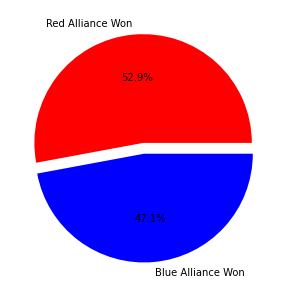

In [54]:
pie_chart_values = [len(df[df.red_won == 1]), len(df[df.red_won != 1])]
labels = ['Red Alliance Won', 'Blue Alliance Won']
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.pie(pie_chart_values, labels=labels, explode=[0, 0.1], autopct='%1.1f%%', colors=['red', 'blue'])

plt.show()

It looks like in our data set, the red alliance wins more often then the blue alliance. This discrepancy might exist due to the fact that the first seeded team in a competition is always the red alliance during a competition. Though the data set is somewhat imbalanced, the discrepancy is not extreme enough for us to want to fix it which may lose the accuracy of our models.

A way we could fix this if we wanted to is by oversampling and undersampling the data.

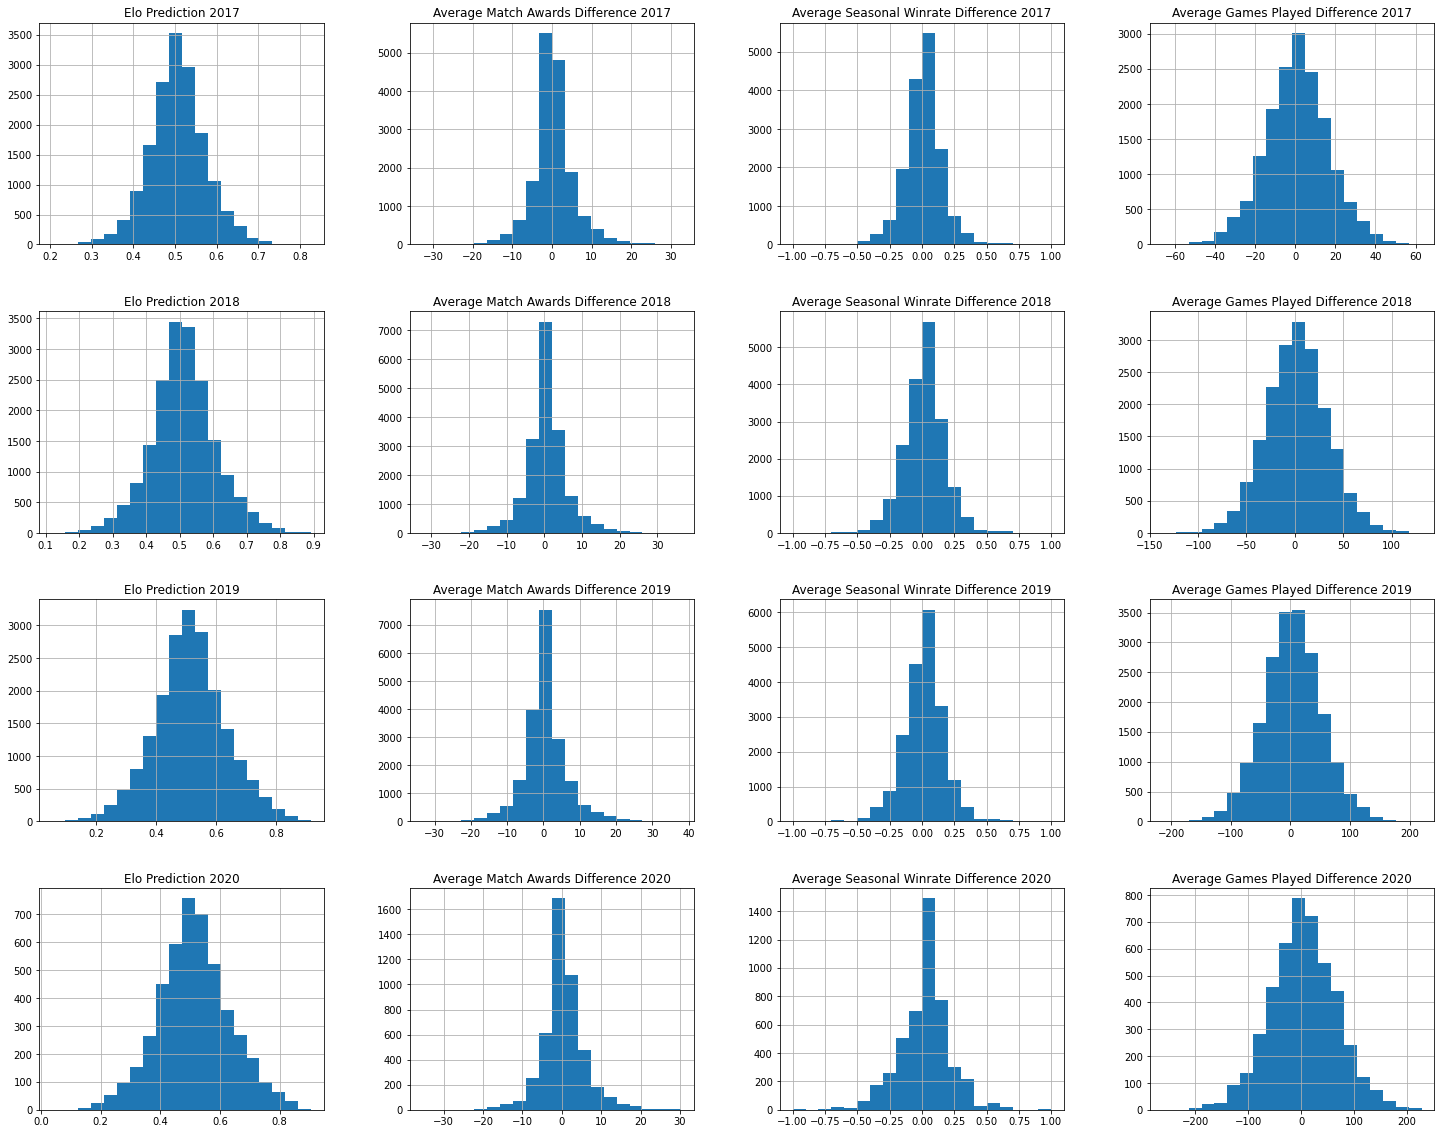

In [55]:
fig, ax = plt.subplots(4, 4, figsize=(25,20))

for i in range(4):
    curr_year = 2017 + i
    year_df = df[df.year == curr_year]
    
    year_df.hist(bins=20, column='elo_prediction', ax=ax[i, 0])
    ax[i, 0].set_title('Elo Prediction ' + str(curr_year))
    
    year_df.hist(bins=20, column='avg_match_awards_diff', ax=ax[i, 1])
    ax[i, 1].set_title('Average Match Awards Difference ' + str(curr_year))
    
    year_df.hist(bins=20, column='avg_winrate_diff_season', ax=ax[i, 2])
    ax[i, 2].set_title('Average Seasonal Winrate Difference ' + str(curr_year))
    
    year_df.hist(bins=20, column='avg_games_played_diff', ax=ax[i, 3])
    ax[i, 3].set_title('Average Games Played Difference ' + str(curr_year))

plt.show()

Looking at these 4 variables between 2017-2020 we see that the values do seem to be in a consistently uniform distribution over the years. 

We can see from the elo predictions, most alliances seem to be equally matched against each other. The average winrate difference per season also show that even if with the game changing every year, the games still seem to be balanced and fair since most alliance match ups have a small winrate difference.

The normal distribution also gives us some ideas on what kind of models we can use.

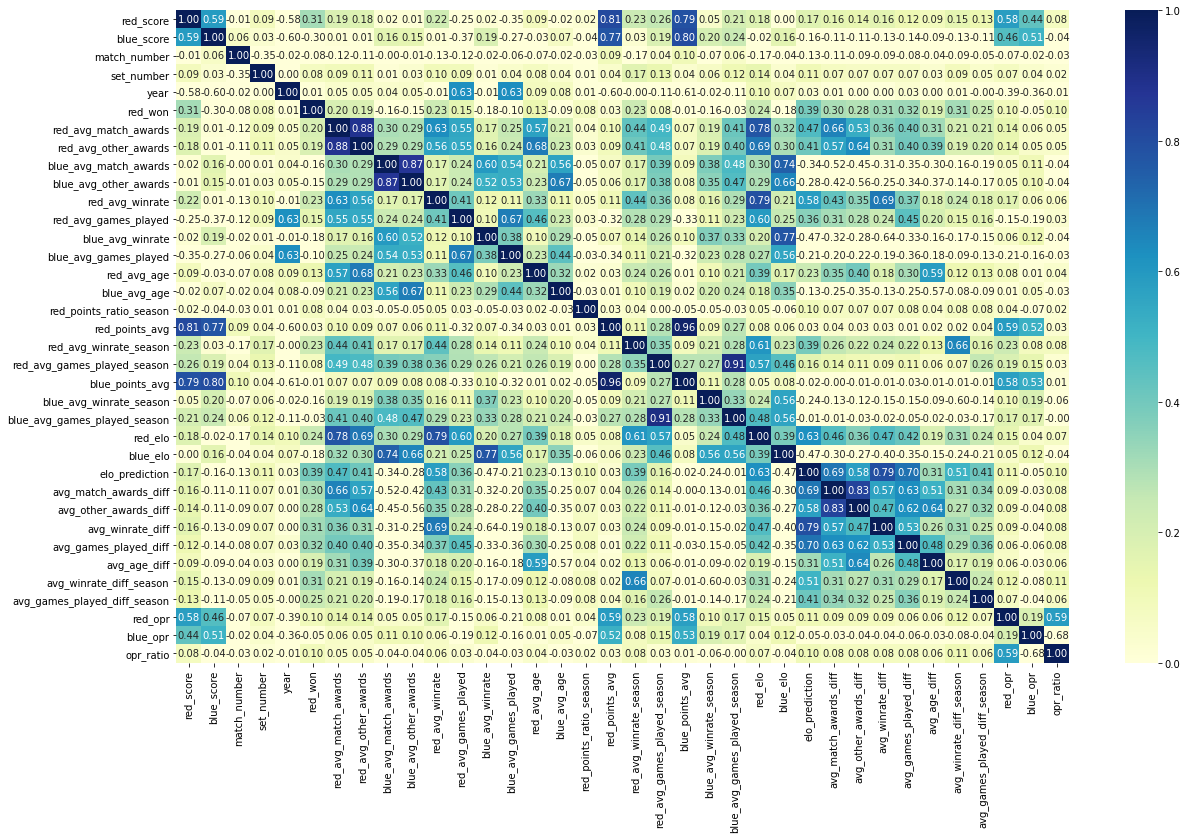

In [56]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=0)

The correlation heatmap shows the linear correlation between two values. The closer the absolute value of a correlation is to 1 the stronger the correlation is. 

Do be wary about some values in the heat map as they may be misleading. For example the blue score and red score seem to be strongly postively correlated to each other and that does not mean that the higher the blue score, the higher the red score will be. Since each year the game is different, the average number of points an alliance gains each year is different.

We can take a look at some of the correlations and see if we can find anything to make our models.

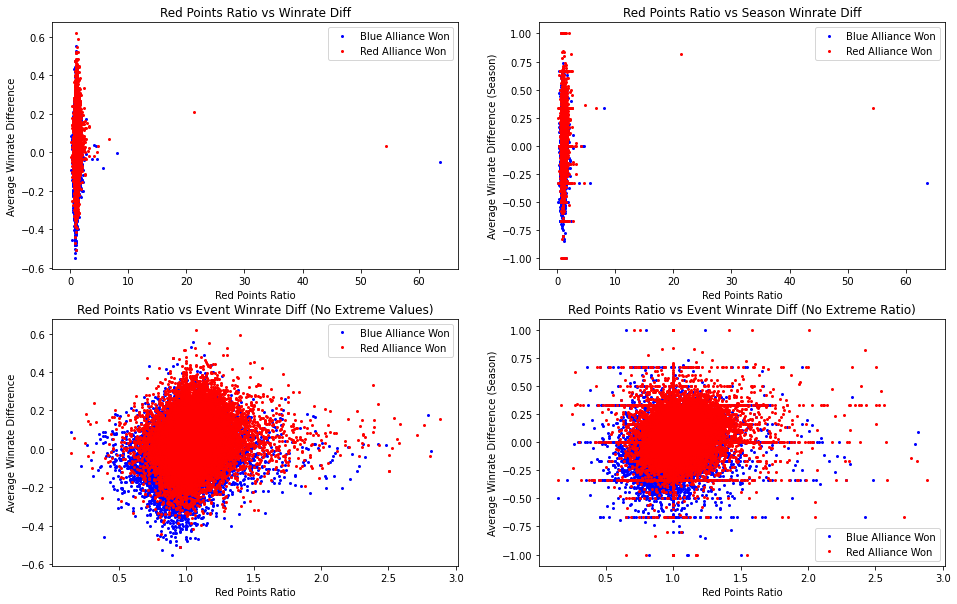

In [57]:
groups = df.groupby('red_won')

fig, ax = plt.subplots(2, 2, figsize=(16,10))

#General Scatter Plot
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0, 0].plot(group.red_points_ratio_season, group.avg_winrate_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0, 0].legend()
ax[0, 0].set_xlabel('Red Points Ratio')
ax[0, 0].set_ylabel('Average Winrate Difference')
ax[0, 0].set_title('Red Points Ratio vs Winrate Diff')

#Getting rid of the extreme cases
for winner, group in groups:
    group = group[group.red_points_ratio_season < 3]
    
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1, 0].plot(group.red_points_ratio_season, group.avg_winrate_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1, 0].legend()
ax[1, 0].set_xlabel('Red Points Ratio')
ax[1, 0].set_ylabel('Average Winrate Difference')
ax[1, 0].set_title('Red Points Ratio vs Event Winrate Diff (No Extreme Values)')

#Seasonal Scatter Plot
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0, 1].plot(group.red_points_ratio_season, group.avg_winrate_diff_season, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0, 1].legend()
ax[0, 1].set_xlabel('Red Points Ratio')
ax[0, 1].set_ylabel('Average Winrate Difference (Season)')
ax[0, 1].set_title('Red Points Ratio vs Season Winrate Diff')

#Getting rid of the extreme cases (Seasonal)
for winner, group in groups:
    group = group[group.red_points_ratio_season < 3]
    
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1, 1].plot(group.red_points_ratio_season, group.avg_winrate_diff_season, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1, 1].legend()
ax[1, 1].set_xlabel('Red Points Ratio')
ax[1, 1].set_ylabel('Average Winrate Difference (Season)')
ax[1, 1].set_title('Red Points Ratio vs Event Winrate Diff (No Extreme Ratio)')

plt.show()

Comparing the red points ratio to the average winrate difference we see that even though there is a lot of noise in the middle, there are two noticeable sections that are forming. When see that there are a lot of blue alliance wins clustered near the bottom-left of each graph. We can also see that the greater the red points ratio is, the more often red alliance wins.

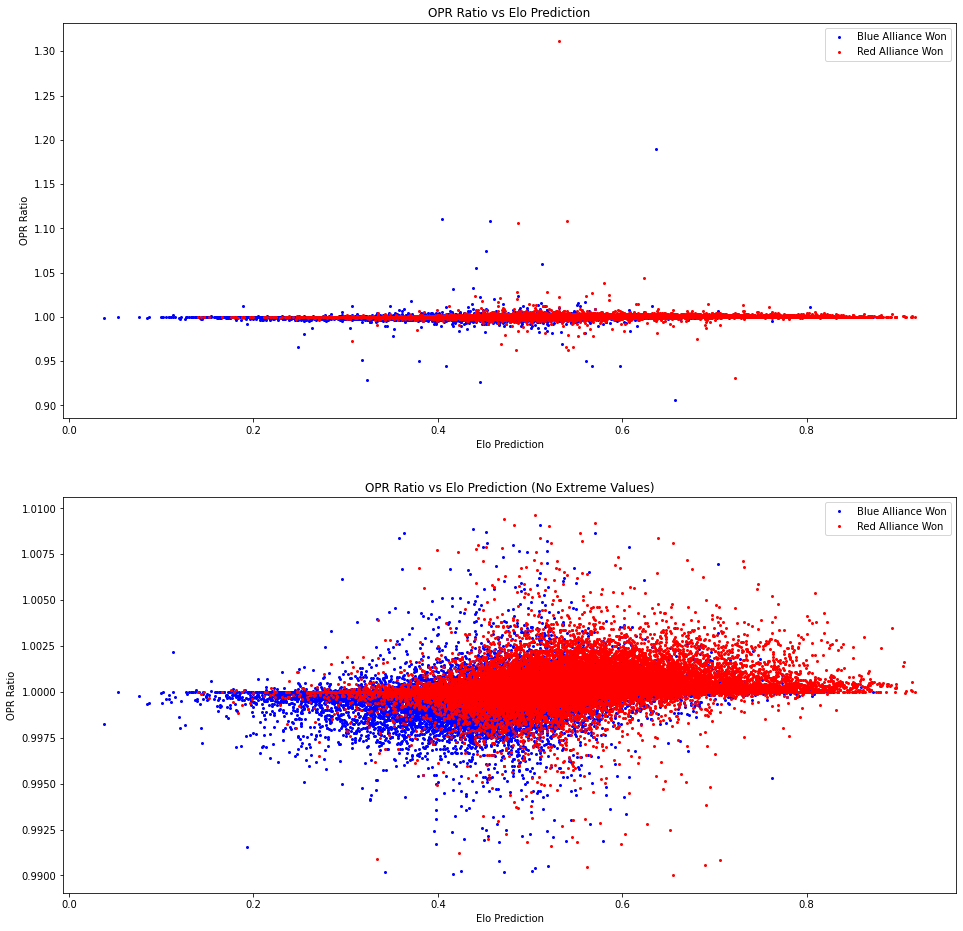

In [58]:
groups = df.groupby('red_won')

fig, ax = plt.subplots(2, 1, figsize=(16,16))

#General Scatter Plot
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0].plot(group.elo_prediction, group.opr_ratio, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0].legend()
ax[0].set_xlabel('Elo Prediction')
ax[0].set_ylabel('OPR Ratio')
ax[0].set_title('OPR Ratio vs Elo Prediction')

#Getting rid of the extreme cases
for winner, group in groups:
    group = group[(group.opr_ratio > 0.99) & (group.opr_ratio < 1.01)]

    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1].plot(group.elo_prediction, group.opr_ratio, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1].legend()
ax[1].set_xlabel('Elo Prediction')
ax[1].set_ylabel('OPR Ratio')
ax[1].set_title('OPR Ratio vs Elo Prediction (No Extreme Values)')

plt.show()

From our comparison with the elo prediction and the match OPR we start to see some more groups forming. It looks like the lower the OPR ratio and the lower the elo prediction, the more likely it is that blue alliance wins.

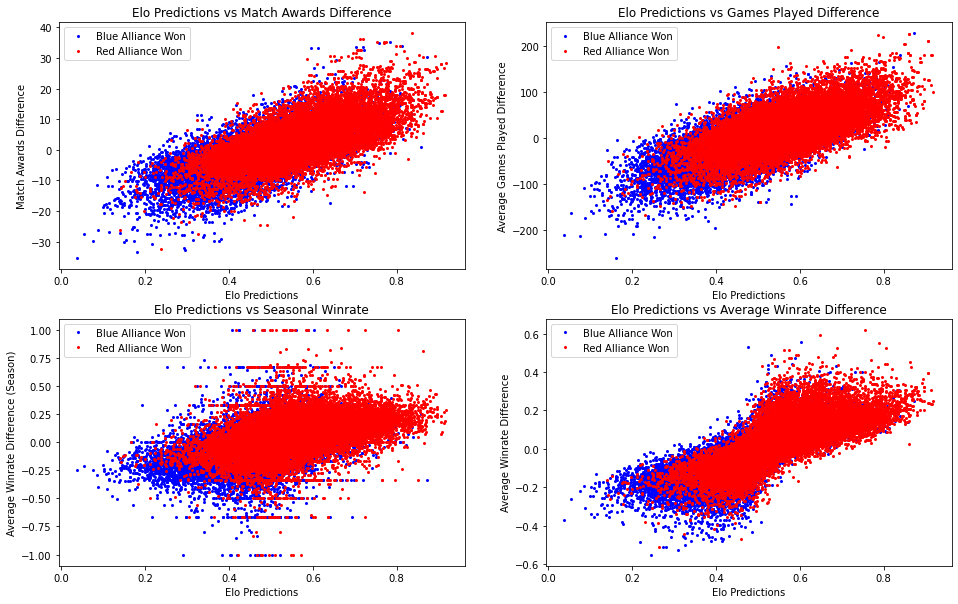

In [59]:
groups = df.groupby('red_won')

fig, ax = plt.subplots(2, 2, figsize=(16,10))

#Elo vs Match Awards
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0, 0].plot(group.elo_prediction, group.avg_match_awards_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0, 0].legend()
ax[0, 0].set_xlabel('Elo Predictions')
ax[0, 0].set_ylabel('Match Awards Difference')
ax[0, 0].set_title('Elo Predictions vs Match Awards Difference')

#Elo vs Winrate Difference (Season)
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1, 0].plot(group.elo_prediction, group.avg_winrate_diff_season, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1, 0].legend()
ax[1, 0].set_xlabel('Elo Predictions')
ax[1, 0].set_ylabel('Average Winrate Difference (Season)')
ax[1, 0].set_title('Elo Predictions vs Seasonal Winrate')

#Elo vs games played
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[0, 1].plot(group.elo_prediction, group.avg_games_played_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[0, 1].legend()
ax[0, 1].set_xlabel('Elo Predictions')
ax[0, 1].set_ylabel('Average Games Played Difference')
ax[0, 1].set_title('Elo Predictions vs Games Played Difference')

#Elo vs Winrate Difference
for winner, group in groups:
    name = 'Red Alliance Won' if winner == 1 else 'Blue Alliance Won'
    color = 'red' if winner == 1 else 'blue'
    ax[1, 1].plot(group.elo_prediction, group.avg_winrate_diff, marker='o', linestyle='', ms=2, label=name, color=color)
ax[1, 1].legend()
ax[1, 1].set_xlabel('Elo Predictions')
ax[1, 1].set_ylabel('Average Winrate Difference')
ax[1, 1].set_title('Elo Predictions vs Average Winrate Difference')

plt.show()

From these elo prediction graphs we can see that there is a positive linear correlation between elo and the other variables.

Seeing that these multiple variables start to group the alliance wins together we can see that there is some hope in being able to create a predictive model and we can get a clue as to what models might be useful for our use case.

## 5.The Predictive Models
Looking at the data and the correlations we found we can choose some independent variables for our models. These independent variables will hopefully influence our dependent variable which is *red_won*.

Looking at the correlation chart we see that there is a high correlation between some of our independent variables. This might show that we have some redundant variables. We can see that *avg_match_awards_diff* and *avg_other_awards_diff* have a pretty high correlation (0.83). We will use *avg_match_awards_diff* since the match awards are more indicative of a team's performance in a match. We can also see that *avg_winrate_diff* and *elo_prediction* are pretty highly correllated (0.79) since they both represent the wins and losses a team has faced in the past. We will be using the *elo_prediction* since the variables also takes into account how likely/unlikely each win was suppose to be.

In [60]:
independent_variables = ['avg_match_awards_diff',
                         'avg_games_played_diff', 'avg_age_diff', 'avg_winrate_diff_season',
                         'avg_games_played_diff_season', 'red_points_ratio_season', 'elo_prediction', 'opr_ratio']
df = df[df['avg_age_diff'].notna()]

Now that we have our independent variables, we need to split the data into a train and test split. We will randomly select 75% of the data we have and train our models on them. We will then see how accurate these models are by comparing the results to our remain 25% of data.

In [61]:
df_scaled = df.copy()
#Getting unscaled slo for pure elo prediction
df_scaled['unscaled_elo_pred'] = df_scaled['elo_prediction']
df_scaled['unscaled_match_opr_pred'] = df_scaled['opr_ratio']

#Feature Scaling to improve KNN
scaler = preprocessing.StandardScaler()
df_scaled[independent_variables] = scaler.fit_transform(df_scaled[independent_variables])

X = df_scaled[independent_variables]
#The data frame is being used here so that we can check on how accurate the model is for specific teams are later on
y = df_scaled



#Splitting our data into a test and train split
X_train,X_test,y_train_prime,y_test_prime = train_test_split(X,y,test_size=0.2, random_state=5406)

y_train, y_test = y_train_prime['red_won'], y_test_prime['red_won']

#Will be used in cross validation to help set some hyperparameters
cv = StratifiedKFold(random_state=5406, shuffle=True)

### Our Models
We will be using four classification models which are Logistic Regression, Naive Bayes, K Nearest Neighbours and Random Forest. We will use a 5 fold cross validation method to ensure that we aren't over fitting the our models. The cross validation method will also help us set some hyperparameters for our models.

In [62]:
#Logistic Regression Model
lr = LogisticRegression(max_iter=4000)

#Cross Validation
score = cross_val_score(lr, X_train, y_train, cv=cv)
print("The average accuracy on all folds is: " + str(np.mean(score) * 100) + "%")

#Prediction on test set
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)

The average accuracy on all folds is: 69.44456701883256%


In [63]:
#Random Forest

#To figure out how many estimators we will use some cross validation
estimators_to_try = [10, 30, 100, 200]
for estimator_attempt in estimators_to_try:
    clf=RandomForestClassifier(n_estimators=estimator_attempt, random_state=5406)
    score = cross_val_score(clf, X_train, y_train, cv=cv)
    
    print("Average accuracy for " + str(estimator_attempt) + " estimators is: " + str(np.mean(score) * 100) + "%")

#Prediction on test set (using 200 estimators since it had the best accuracy)
clf=RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
y_clf_pred = clf.predict(X_test)

Average accuracy for 10 estimators is: 66.97124988224064%
Average accuracy for 30 estimators is: 68.76503910367909%
Average accuracy for 100 estimators is: 69.58384826266001%
Average accuracy for 200 estimators is: 69.86029859655332%


In [64]:
#K Nearest Neighbours

#To figure out how many neighbours we will use some cross validation
n_neighbours_to_try = [11, 71, 151, 301, 501, 1001]
for n_neighbours in n_neighbours_to_try:
    knn = KNeighborsClassifier(n_neighbors=n_neighbours)
    score = cross_val_score(knn, X_train, y_train, cv=cv)
    
    print("Average accuracy for " + str(n_neighbours) + " neighbours is: " + str(np.mean(score) * 100) + "%")

#Prediction on test set. We will be using 501 neighbours
knn = KNeighborsClassifier(n_neighbors=501)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)

Average accuracy for 11 neighbours is: 67.2857065148766%
Average accuracy for 71 neighbours is: 69.45089680031417%
Average accuracy for 151 neighbours is: 69.47200564630403%
Average accuracy for 301 neighbours is: 69.54375318946686%
Average accuracy for 501 neighbours is: 69.57329573227598%
Average accuracy for 1001 neighbours is: 69.42135381218482%


In [65]:
#Naive Bayes
#Gaussian Naive Bayes will be used since the variable follow a normal distribution
nb = GaussianNB()

#Cross Validation
score = cross_val_score(nb, X_train, y_train, cv=cv)
print("The average accuracy on all folds is: " + str(np.mean(score) * 100) + "%")

#Prediction on test set
nb.fit(X_train, y_train)
y_nb_pred = nb.predict(X_test)

The average accuracy on all folds is: 66.8003273014488%


Now that our models have been created and fitted let us see how well they did

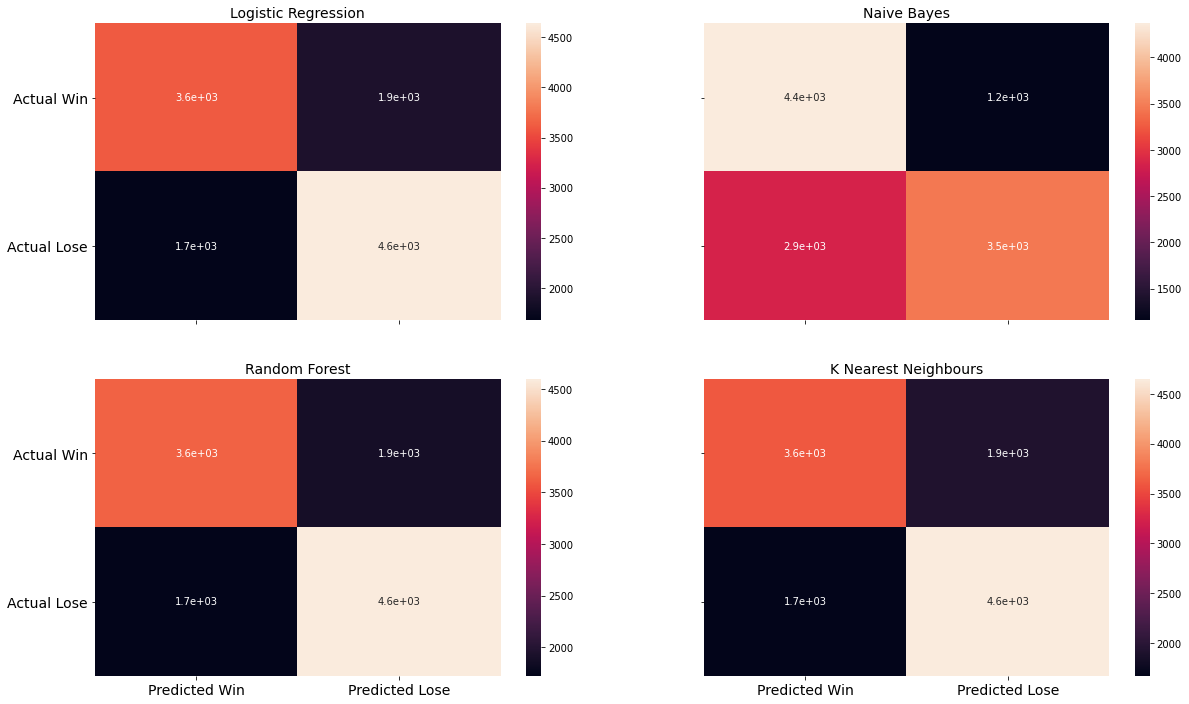

In [66]:
#Create confusion matrices
lr_cf = metrics.confusion_matrix(y_test, y_lr_pred)
clf_cf = metrics.confusion_matrix(y_test, y_clf_pred)
knn_cf = metrics.confusion_matrix(y_test, y_knn_pred)
nb_cf = metrics.confusion_matrix(y_test, y_nb_pred)

#Create foundation to display 4 plots
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

#Display heat maps
sns.heatmap(lr_cf, ax=ax[0][0], annot=True)
ax[0, 0].set_title('Logistic Regression', fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14)
ax[0, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(clf_cf, ax=ax[1][0], annot=True)
ax[1, 0].set_title('Random Forest', fontsize=14)
ax[1, 0].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(nb_cf, ax=ax[0][1], annot=True)
ax[0, 1].set_title('Naive Bayes', fontsize=14)
ax[0, 1].set_xticklabels(['', ''], fontsize=14)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

sns.heatmap(knn_cf, ax=ax[1][1], annot=True)
ax[1, 1].set_title('K Nearest Neighbours', fontsize=14)
ax[1, 1].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

plt.show()

In [67]:
#Logistic Regression Report
print('Logistic Regression:')
print(metrics.classification_report(y_test, y_lr_pred))

#Random Forest Report
print('\nRandom Forest:')
print(metrics.classification_report(y_test, y_clf_pred))

#Naive Bayes Report
print('\nNaive Bayes:')
print(metrics.classification_report(y_test, y_nb_pred))

#K Nearest Neighbours Report
print('\nK Nearest Neighbours:')
print(metrics.classification_report(y_test, y_knn_pred))

#Pure Elo
print('\nPure Elo')
y_elo_pred = y_test_prime.copy()
y_elo_pred[y_elo_pred.unscaled_elo_pred >= 0.5] = 1
y_elo_pred[y_elo_pred.unscaled_elo_pred < 0.5] = 0

print(metrics.classification_report(y_test, y_elo_pred['unscaled_elo_pred']))

#Pure Match OPR
print('\nMatch OPR')
y_m_opr_pred = y_test_prime.copy()
y_m_opr_pred[y_elo_pred.unscaled_match_opr_pred >= 1] = 1
y_m_opr_pred[y_elo_pred.unscaled_match_opr_pred < 1] = 0

print(metrics.classification_report(y_test, y_m_opr_pred['unscaled_match_opr_pred']))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      5528
           1       0.71      0.73      0.72      6319

    accuracy                           0.70     11847
   macro avg       0.70      0.69      0.69     11847
weighted avg       0.70      0.70      0.70     11847


Random Forest:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      5528
           1       0.71      0.73      0.72      6319

    accuracy                           0.70     11847
   macro avg       0.69      0.69      0.69     11847
weighted avg       0.69      0.70      0.69     11847


Naive Bayes:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68      5528
           1       0.75      0.55      0.63      6319

    accuracy                           0.66     11847
   macro avg       0.68      0.67      0.66     11847
weighted avg       0.68

Looking at the classification report we see that our most accurate models are the Random Forest model, KNN model and the Logistic Regression model. We see that the three models give us more or less the same results. We can note that our Random Forest model has a slightly better recall than the other two

The Naive Bayes model seems to actually be the best at catching all of the losses with a recall score of 79% and it actually does the best when predicting losses as shown by its f1-score. Though its ability to predict losses better comes at a cost of being the worst when it comes to predicting wins.

## 6.Conclusion
From exploring the data and comparing models we seem to be able to see which model works best for predicting match outcomes. The Random Forest model we created appears to be the most accurate being 70% accurate.

Now this model definitely does not replace scouting out other teams and doing your own research especially due to its accuracy but if you are stuck choosing between two teams then the model is technically better than a coin flip!

### Final thoughts

There are some caveats with the model and our features. One of them is the OPR ratio feature. While handles what we want it to do which is comparing the red alliance OPR and the blue alliance OPR, the feature isn't perfect. As of right now we are assuming that an OPR never goes above 100,000. Also, games where the red alliance has double the OPR value of the blue alliance will have different OPR ratios depending on the season which isn't ideal. 

We also only calculated the event/competition OPR. It is possible to calculate the seasonal OPR but with the sheer number of events that occur each season and the number of teams that exist, the current code that calculates seasonal OPR takes more than a day to run on the Google Colab GPU.

We may return to fix/alter these problems in the future.

## 7.Seeing How Our Friends Are Doing
Since we have found the model, let us see how well it did on 4 arbitrary (they are not arbitrary) teams during my last year in robotics.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


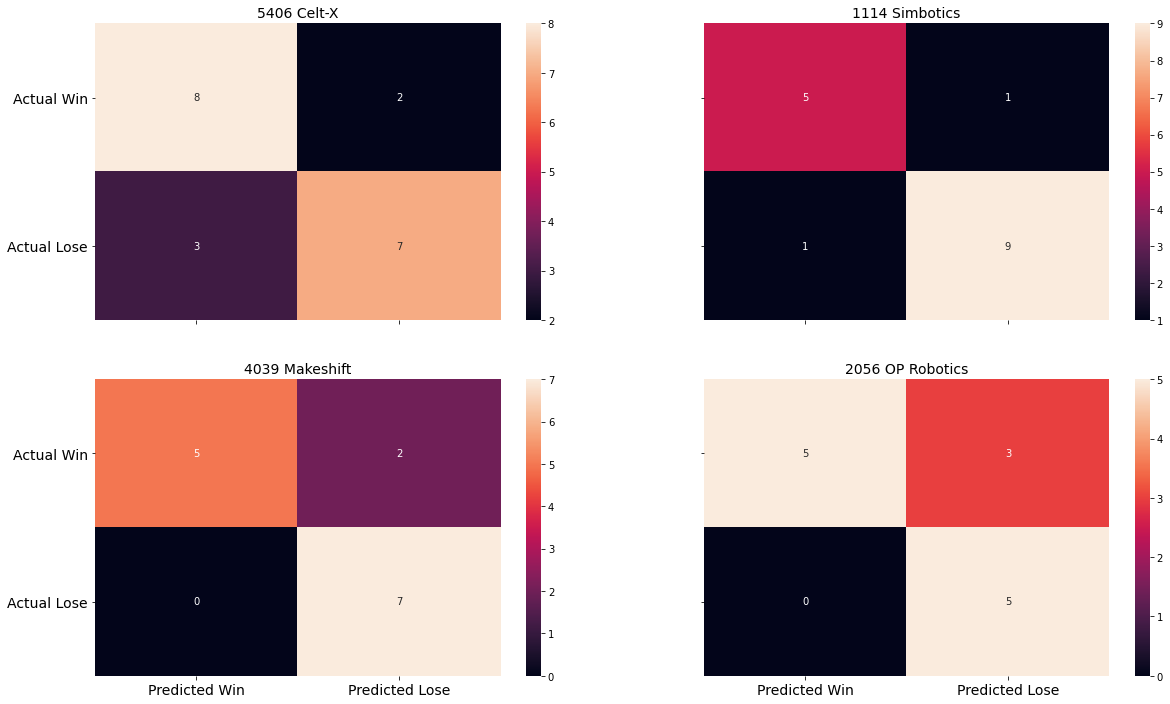

In [68]:
def get_team_test(team_key):
    team_test_df = y_test_prime[(df.red_0 == team_key) | (df.red_1 == team_key) | (df.red_2 == team_key) | (df.blue_0 == team_key) | (df.blue_1 == team_key) | (df.blue_2 == team_key)]
    return team_test_df[team_test_df.year == 2018]

#Get the test values from TOTALLY ARBITRARY teams
frc5406_test = get_team_test('frc5406')
frc4039_test = get_team_test('frc4039')
frc1114_test = get_team_test('frc1114')
frc2056_test = get_team_test('frc2056')

#Make predictions
celt_pred = clf.predict(frc5406_test[independent_variables])
make_pred = clf.predict(frc4039_test[independent_variables])
sim_pred = clf.predict(frc1114_test[independent_variables])
op_pred = clf.predict(frc2056_test[independent_variables])

#Create confusion matrices
celt_cf = metrics.confusion_matrix(frc5406_test['red_won'], celt_pred)
make_cf = metrics.confusion_matrix(frc4039_test['red_won'], make_pred)
sim_cf = metrics.confusion_matrix(frc1114_test['red_won'], sim_pred)
op_cf = metrics.confusion_matrix(frc2056_test['red_won'], op_pred)

#Create foundation to display 4 plots
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

#Display heat maps
sns.heatmap(celt_cf, ax=ax[0][0], annot=True)
ax[0, 0].set_title('5406 Celt-X', fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14)
ax[0, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(make_cf, ax=ax[1][0], annot=True)
ax[1, 0].set_title('4039 Makeshift', fontsize=14)
ax[1, 0].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 0].set_yticklabels(['Actual Win', 'Actual Lose'], fontsize=14, rotation=0)

sns.heatmap(sim_cf, ax=ax[0][1], annot=True)
ax[0, 1].set_title('1114 Simbotics', fontsize=14)
ax[0, 1].set_xticklabels(['', ''], fontsize=14)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

sns.heatmap(op_cf, ax=ax[1][1], annot=True)
ax[1, 1].set_title('2056 OP Robotics', fontsize=14)
ax[1, 1].set_xticklabels(['Predicted Win', 'Predicted Lose'], fontsize=14)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=0)

plt.show()

In [69]:
#Okay accuracy for my old team
print('5406 Accuracy: ' + str(metrics.accuracy_score(frc5406_test['red_won'], celt_pred)))
#Surprisingly good accuracy for our neighbours
print('4039 Accuracy: ' + str(metrics.accuracy_score(frc4039_test['red_won'], make_pred)))
#Once again pretty good accuracy
print('1114 Accuracy: ' + str(metrics.accuracy_score(frc1114_test['red_won'], sim_pred)))
#See above for same reaction
print('2056 Accuracy: ' + str(metrics.accuracy_score(frc2056_test['red_won'], op_pred)))

5406 Accuracy: 0.75
4039 Accuracy: 0.8571428571428571
1114 Accuracy: 0.875
2056 Accuracy: 0.7692307692307693


In [70]:
#Yearly accuracy
for year in range(2017, 2021):
    pred = lr.predict(y_test_prime[y_test_prime.year == year][independent_variables])
    print(str(year) + ' Accuracy: ' + str(metrics.accuracy_score(y_test_prime[y_test_prime.year == year]['red_won'], pred)) + '\n')

2017 Accuracy: 0.6605143721633888

2018 Accuracy: 0.7254120148856991

2019 Accuracy: 0.7005941617153191

2020 Accuracy: 0.6908690869086909

